In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## S&P 500 Tickers

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_df = tables[0][['Symbol', 'Security', 'GICS Sector']]
sp500_df.columns = ['Ticker', 'Company', 'Sector']
sp500_df.head()

  Ticker              Company                  Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


## Ticker Metrics Fetching

In [ ]:
tqdm.pandas()
def fetch_financial_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return pd.Series({
            'MarketCap': info.get('marketCap', np.nan),
            'PE': info.get('trailingPE', np.nan),
            'PB': info.get('priceToBook', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'ROA': info.get('returnOnAssets', np.nan),
            'DividendYield': info.get('dividendYield', np.nan),
            'DebtToEquity': info.get('debtToEquity', np.nan),
            'EBITDA': info.get('ebitda', np.nan),
            'OperatingMargin': info.get('operatingMargins', np.nan)
        })
    except:
        return pd.Series({col: np.nan for col in [
            'MarketCap', 'PE', 'PB', 'ROE', 'ROA', 'DividendYield', 'DebtToEquity', 'EBITDA', 'OperatingMargin']})
sp500_df[[
    'MarketCap', 'PE', 'PB', 'ROE', 'ROA', 'DividendYield', 'DebtToEquity', 'EBITDA', 'OperatingMargin'
]] = sp500_df['Ticker'].progress_apply(fetch_financial_data)
sp500_df.dropna(subset=['MarketCap'], inplace=True)

## Define per-sector metrics

In [ ]:
sector_metric = {
    'Information Technology': 'PE',
    'Health Care': 'ROE',
    'Financials': 'ROE',
    'Consumer Discretionary': 'OperatingMargin',
    'Communication Services': 'EBITDA',
    'Industrials': 'ROE',
    'Consumer Staples': 'DividendYield',
    'Energy': 'ROA',
    'Utilities': 'DividendYield',
    'Real Estate': 'PE',
    'Materials': 'PE'
}

## Select top 5 by MarketCap in each sector

In [ ]:
top5_per_sector = sp500_df.groupby('Sector').apply(lambda x: x.nlargest(5, 'MarketCap')).reset_index(drop=True)

## Rank inside each sector

In [ ]:
def rank_top5(df):
    sector = df['Sector'].iloc[0]
    metric = sector_metric.get(sector, 'MarketCap')
    return df.sort_values(by=metric, ascending=False).reset_index(drop=True)
ranked_df = top5_per_sector.groupby('Sector', group_keys=False).apply(rank_top5)
ranked_df.head(10)

100%|█████████████████████████████████████████| 500/500 [09:27<00:00,  1.14s/it]
/var/folders/c6/z7pdynp14jd16wp1d1c7cvsc0000gn/T/ipykernel_98182/2514208206.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_per_sector = sp500_df.groupby('Sector').apply(lambda x: x.nlargest(5, 'MarketCap')).reset_index(drop=True)
/var/folders/c6/z7pdynp14jd16wp1d1c7cvsc0000gn/T/ipykernel_98182/2514208206.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns 

,Ticker,Company,Sector,MarketCap,PE,PB,ROE,ROA,DividendYield,DebtToEquity,EBITDA,OperatingMargin
0,GOOGL,Alphabet Inc. (Class A),Communication Services,2.184126e+12,20.036830,6.320366,0.34789,0.16897,0.48,8.254,1.357050e+11,0.33918
1,GOOG,Alphabet Inc. (Class C),Communication Services,2.184113e+12,20.150670,6.356275,0.34789,0.16897,0.47,8.254,1.357050e+11,0.33918
2,META,Meta Platforms,Communication Services,1.807829e+12,28.086329,9.804192,0.39835,0.17880,0.28,26.763,8.798000e+10,0.41487
3,TMUS,T-Mobile US,Communication Services,2.733596e+11,23.533726,4.481071,0.19351,0.05600,1.48,199.152,3.160200e+10,0.22982
4,NFLX,Netflix,Communication Services,5.520422e+11,61.361404,22.980904,0.40842,0.13789,NaN,72.513,1.145383e+10,0.31747
0,MCD,McDonald's,Consumer Discretionary,2.102769e+11,25.978798,-60.873524,NaN,0.13416,2.42,NaN,1.389600e+10,0.44577
1,BKNG,Booking Holdings,Consumer Discretionary,1.860264e+11,35.587646,-30.584860,NaN,0.17963,0.66,NaN,8.500000e+09,0.22974
2,HD,Home Depot (The),Consumer Discretionary,3.697948e+11,25.249998,46.489056,2.99519,0.15122,2.51,778.781,2.549800e+10,0.12879
3,AMZN,Amazon,Consumer Discretionary,2.371810e+12,36.385994,7.751909,0.25240,0.07632,NaN,51.641,1.261440e+11,0.11823
4,TSLA,"Tesla, Inc.",Consumer Discretionary,1.015730e+12,182.283230,13.602054,0.08774,0.03724,NaN,17.407,1.255000e+10,0.02550


## Visualization

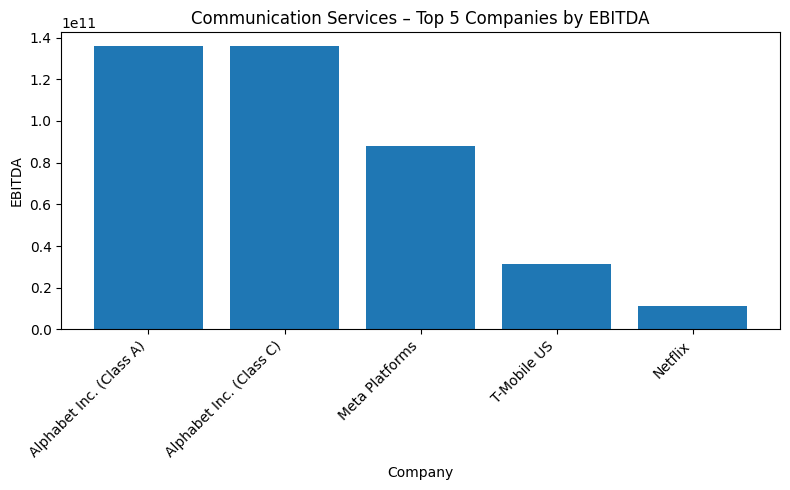

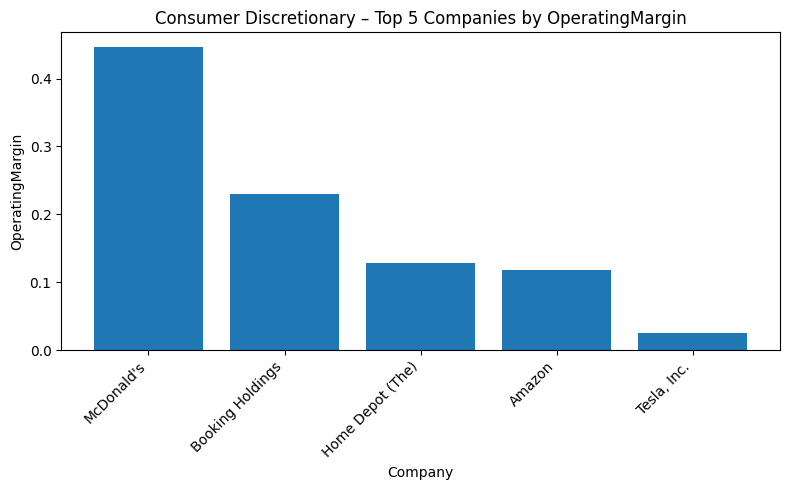

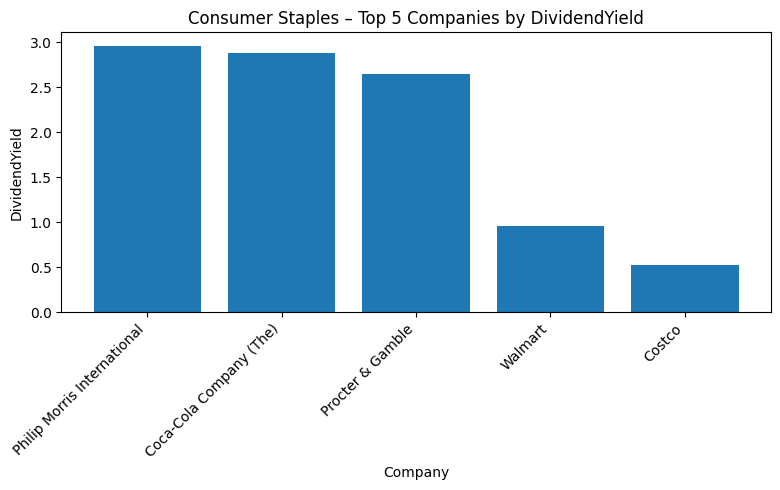

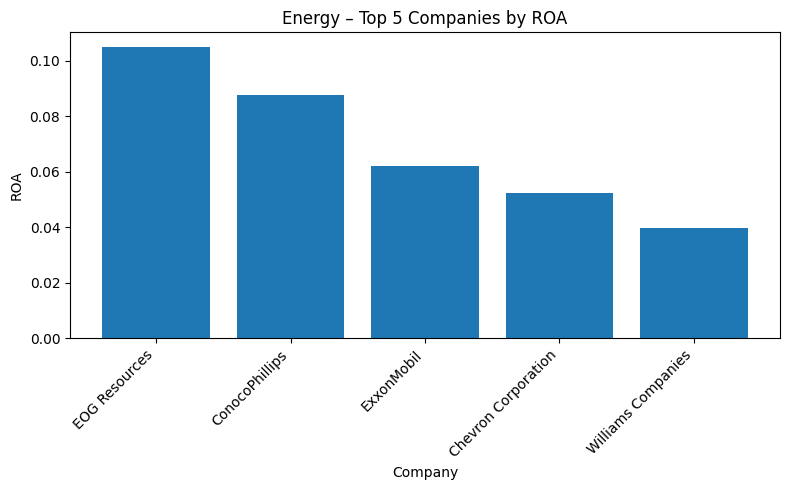

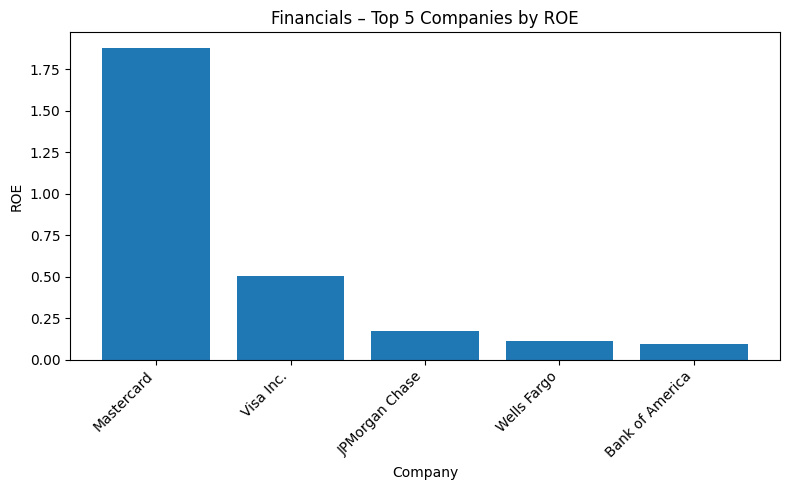

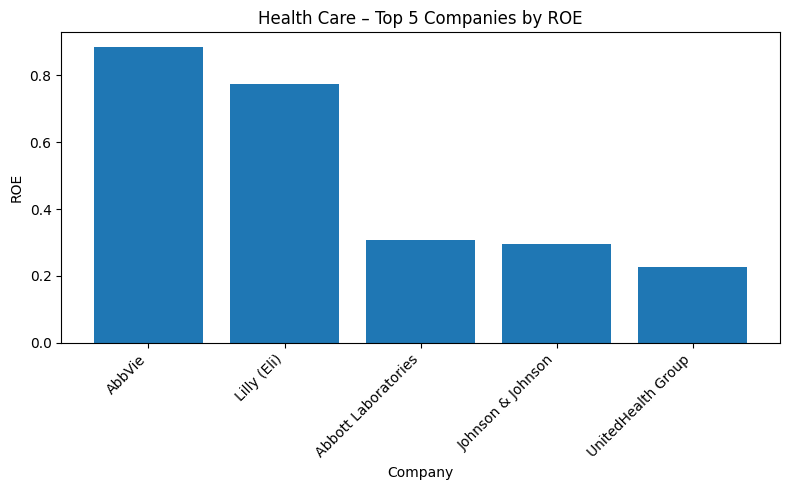

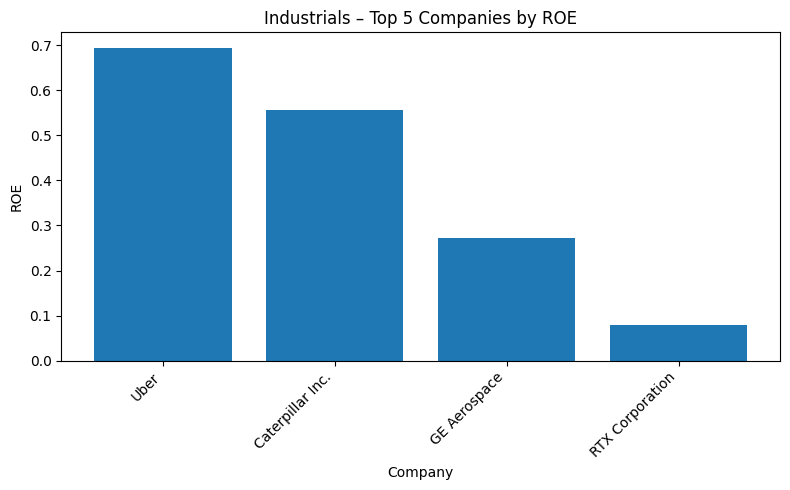

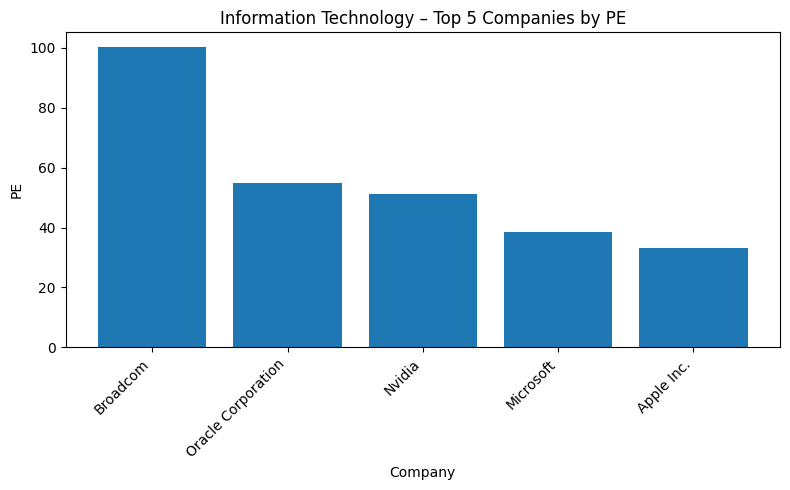

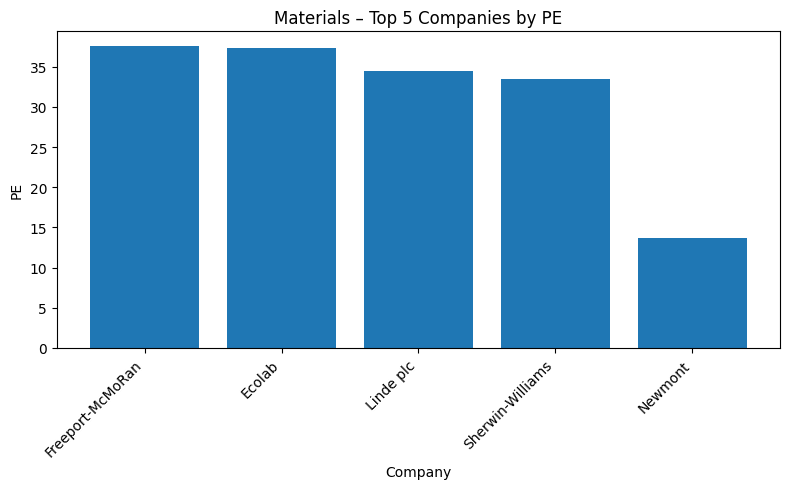

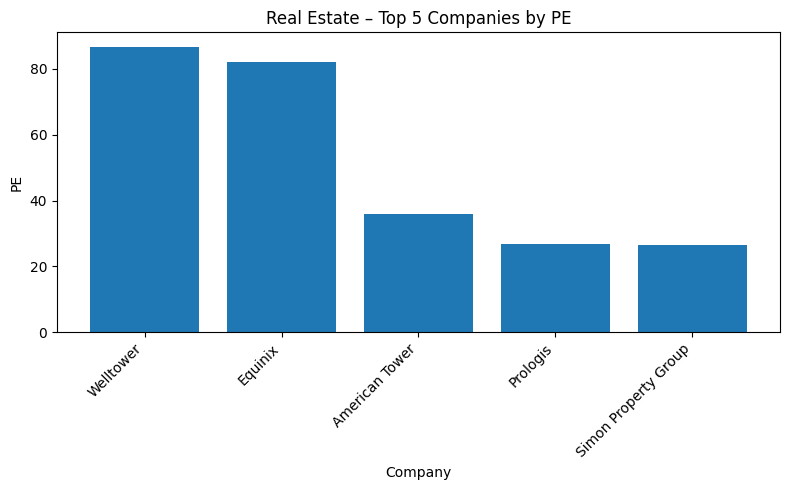

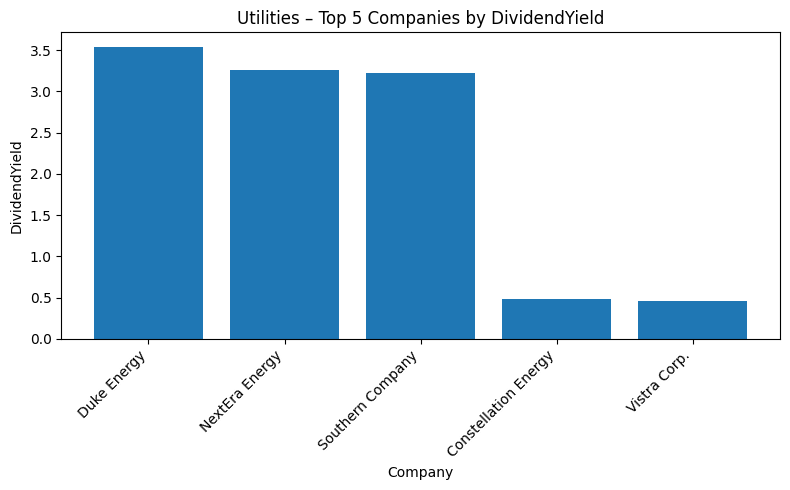

In [12]:
sector_metric = {
    'Information Technology': 'PE',
    'Health Care': 'ROE',
    'Financials': 'ROE',
    'Consumer Discretionary': 'OperatingMargin',
    'Communication Services': 'EBITDA',
    'Industrials': 'ROE',
    'Consumer Staples': 'DividendYield',
    'Energy': 'ROA',
    'Utilities': 'DividendYield',
    'Real Estate': 'PE',
    'Materials': 'PE'
}
for sector in ranked_df['Sector'].unique():
    df_sector = ranked_df[ranked_df['Sector'] == sector]
    metric = sector_metric.get(sector)
    if metric not in df_sector.columns or df_sector[metric].isna().all():
        continue
    df_sector = df_sector.dropna(subset=[metric])
    df_sector = df_sector.sort_values(by=metric, ascending=False)
    plt.figure(figsize=(8, 5))
    plt.bar(df_sector['Company'], df_sector[metric])
    plt.title(f"{sector} – Top 5 Companies by {metric}")
    plt.ylabel(metric)
    plt.xlabel("Company")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()